# Gaussian Mixtures

Sometimes, our data look like they are generated by a "mixture" model. What do we mean by that? In statistics land, it means we believe that there are "mixtures" of subpopulations generating the data that we observe. A common activity, then, is to estimate the subpopulation parameters.

Let's take a look at it by generating some simulated data to illustrate the point.

In [1]:
import sys
sys.executable

'/Users/maer3/anaconda/envs/bayesian/bin/python'

In [2]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/maer3/anaconda/envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We will start by first generating a mixture distribution that is composed of unit width Gaussians (i.e. $ N(\mu, 1) $) that are slightly overlapping.

$$ pop \sim GaussianMixture(\mu=[0, 3], \sigma=[1, 1]) $$

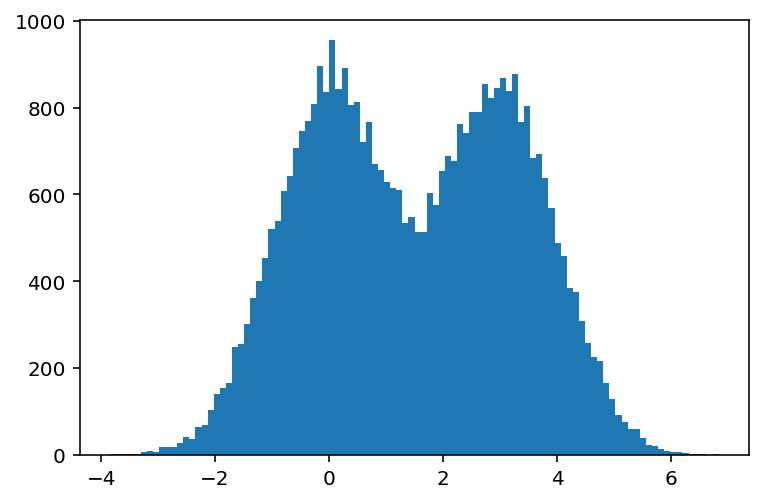

In [18]:
def generate_mixture_data(mus, sizes):
    """
    Generates mixture data
    """
    subpop1 = np.random.normal(loc=mus[0], scale=1, size=sizes[0])
    subpop2 = np.random.normal(loc=mus[1], scale=1, size=sizes[1])
    mixture = np.concatenate([subpop1, subpop2])
    return mixture

mixture = generate_mixture_data(mus=[0, 3], sizes=[20000, 20000])
plt.hist(mixture, bins=100)
plt.show()

Just to reiterate the point, one of the Gaussian distributions has a mean at 0, and the other has a mean at 3. Both subpopulations are present in equal proportions in the larger population, i.e. they have equal weighting.

Let's see if we can use PyMC3 to recover those parameters. Since we know that there are two mixture components, we can encode this in the model.

In [15]:
with pm.Model() as model:
    mu = pm.Cauchy('mu', alpha=1, beta=1, shape=(2,))
    sd = pm.HalfCauchy('sd', beta=1, shape=(2,))
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.NormalMixture('like', w=w, mu=mu, sd=sd, observed=mixture)

In [16]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/bayesian/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [01:31<00:00, 27.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a004358>,
      dtype=object)

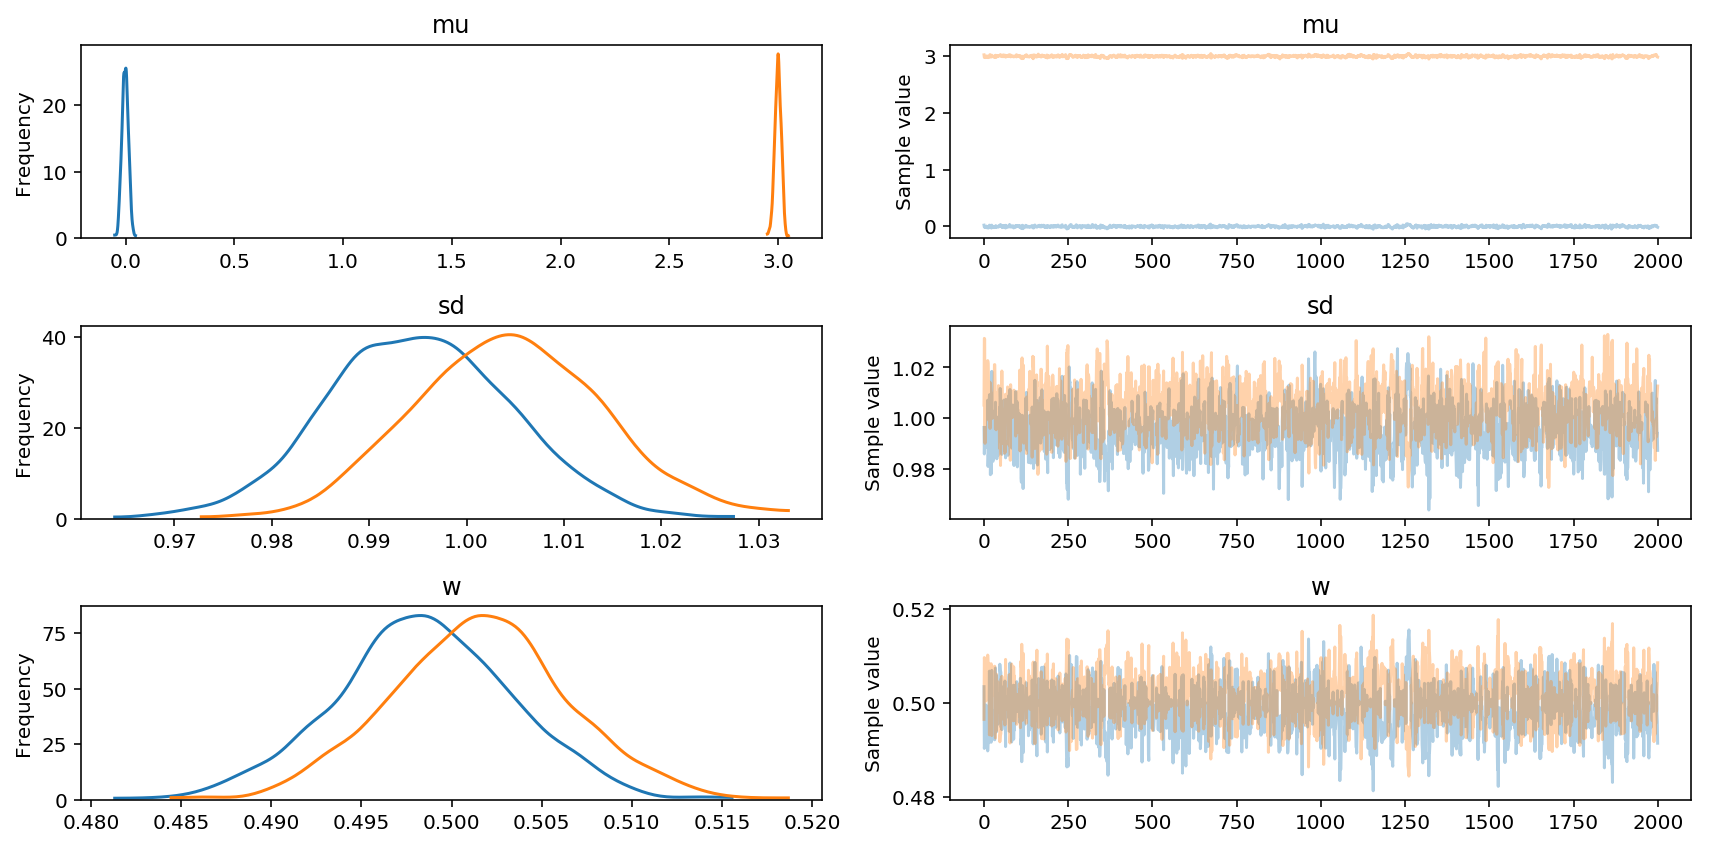

In [17]:
pm.traceplot(trace)

Now, sometimes, in our final population, one sub-population is present at a lower frequency than the other sub-population. Let's try to simulate that.

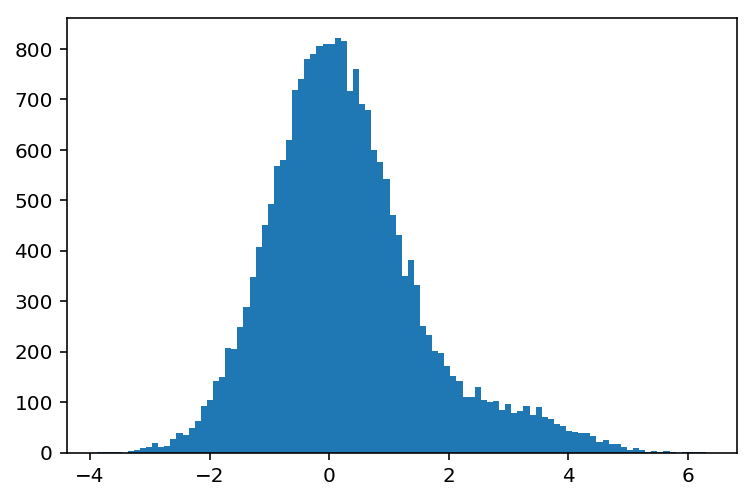

In [19]:
mixture = generate_mixture_data(mus=[0, 3], sizes=[20000, 2000])  # One is at 1/10 the size of the other.
plt.hist(mixture, bins=100)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/bayesian/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [01:10<00:00, 35.62it/s]


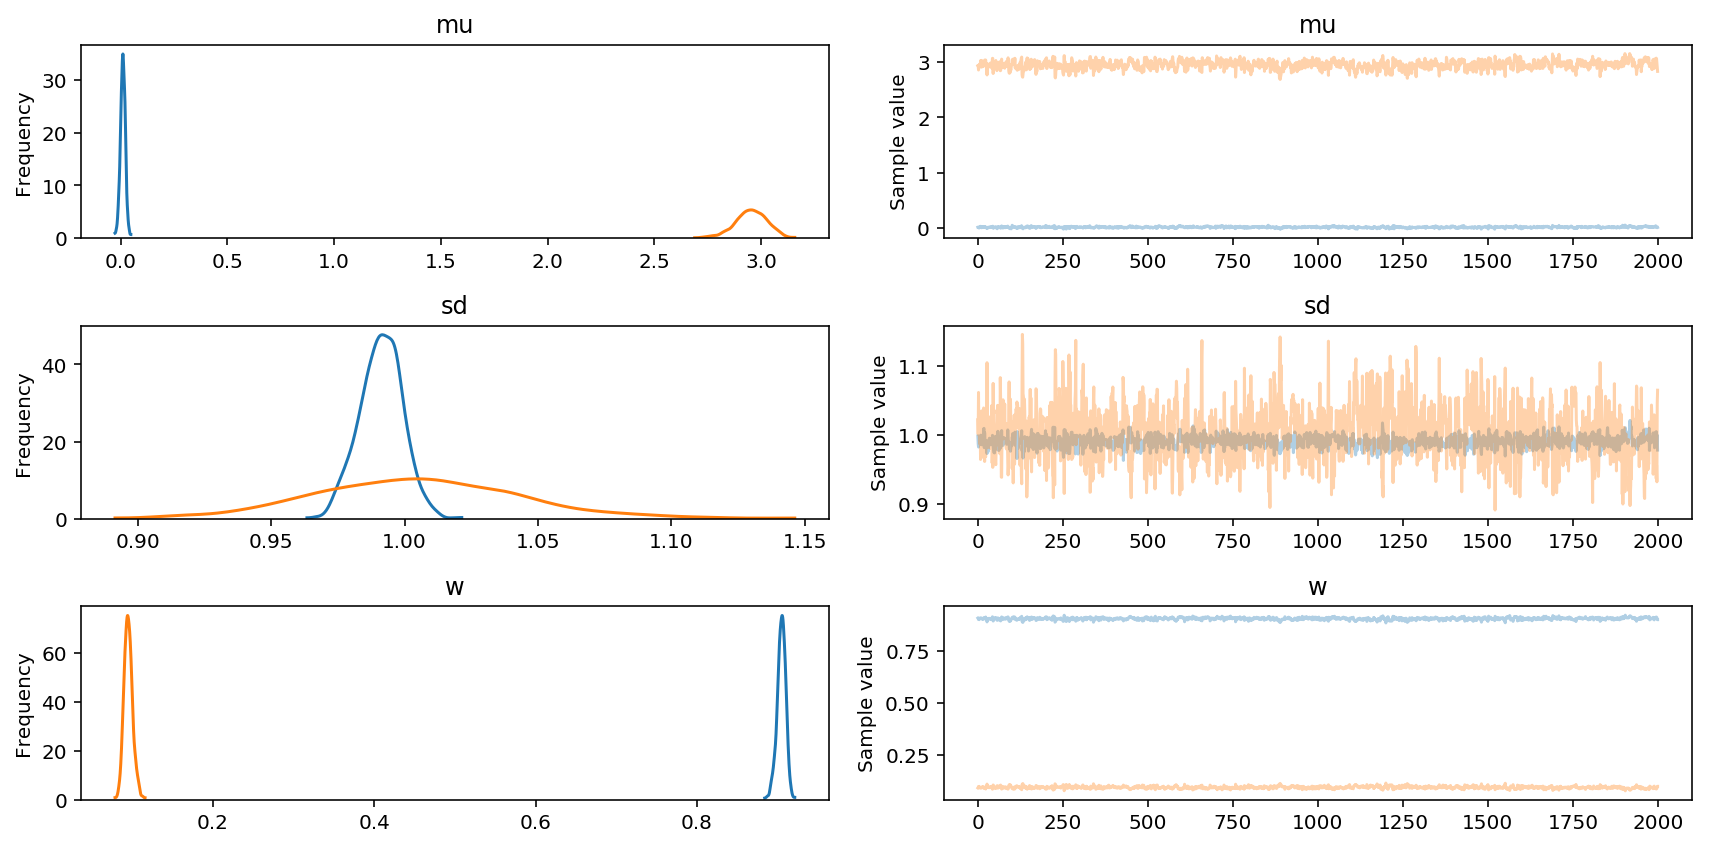

In [21]:
with pm.Model() as model:
    mu = pm.Cauchy('mu', alpha=1, beta=1, shape=(2,))
    sd = pm.HalfCauchy('sd', beta=1, shape=(2,))
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.NormalMixture('like', w=w, mu=mu, sd=sd, observed=mixture)

with model:
    trace = pm.sample(2000)
    pm.traceplot(trace)

This is really good. We have fewer samples for the group with $ \mu = 3 $, which thus means that we are much less confident about the value of $ \mu $ and $ \sigma $. What's neat is that we are nonetheless equally confident of the relative weighting of the two groups: one is much smaller in proportion than the other!

# Generalized Mixtures

We used Gaussian (a.k.a. Normal) distributions for generating the data. However, what if the data didn't come from a Gaussian distribution, but instead came from two Poissons?

In [24]:
def generate_poisson_mixtures(lams, sizes):
    grp1 = np.random.poisson(lam=lams[0], size=sizes[0])
    grp2 = np.random.poisson(lam=lams[1], size=sizes[1])
    
    mixture = np.concatenate([grp1, grp2])
    return mixture

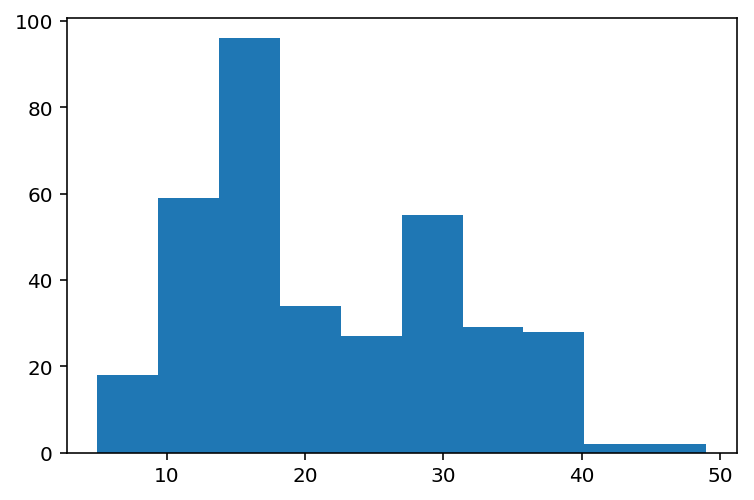

In [29]:
mixture = generate_poisson_mixtures(lams=[14, 30], sizes=[200, 150])
plt.hist(mixture)
plt.show()

In [34]:
with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))
    components = pm.Poisson('components', mu=lam, shape=(2,))
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=mixture)

ValueError: length not known: components [id A]
